In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

First we use hub to load a MobileNetV2 model. We upload the full model as we have done before.

Model is pre-trained on ImageNet (ILSVRC-2012-CLS).

In [2]:
classifier_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

Download a single image to try the model on.

237568/231127 [==============================] - 0s 0us/step


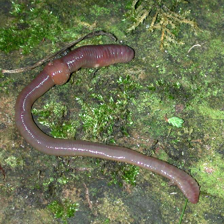

In [4]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://upload.wikimedia.org/wikipedia/commons/3/30/Regenwurm1.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [5]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dim

In [6]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [7]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

53

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


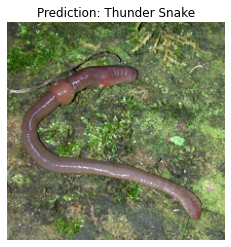

In [9]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

simple "transfer"

I will use a preset

In [10]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 1s 0us/step


In [11]:
batch_size = 128
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [13]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


Now run the classifier on the image batch.

In [16]:
result_batch = classifier.predict(train_ds)

In [17]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'fly', 'daisy', ..., 'cardoon', 'daisy', 'daisy'],
      dtype='<U30')

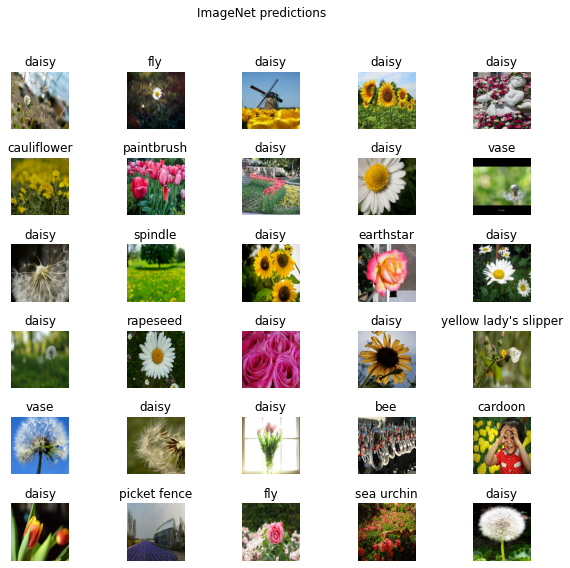

In [18]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

Now we import the "headless" model. Basically we freeze all the layers except for the ones responsible for the classification, hoping that feature exctractor can handle the task with learned features.

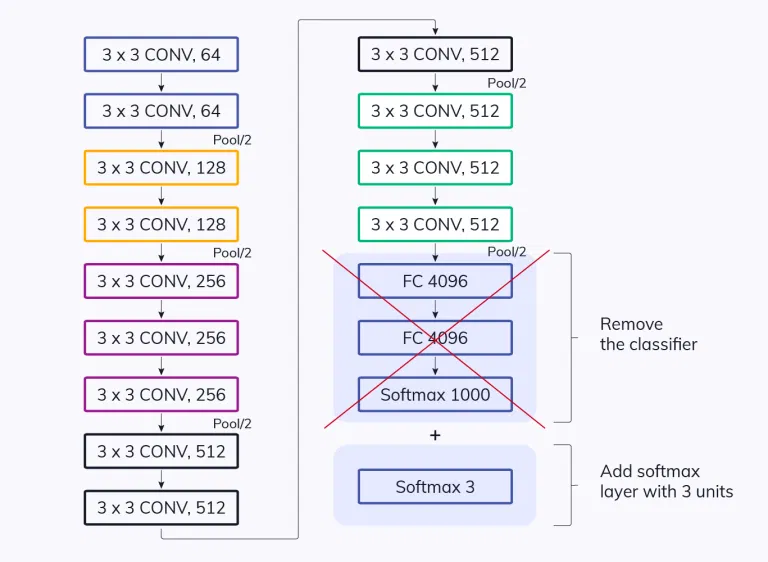

In [41]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [42]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [43]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(128, 1280)


In [44]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [45]:
predictions = model(image_batch)

In [46]:
predictions.shape

TensorShape([128, 5])

In [47]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [48]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=4,
                    callbacks=[batch_stats_callback])

Epoch 1/4
23/23 [==============================] - 6s 140ms/step - loss: 0.5496 - acc: 0.8250
Epoch 2/4
23/23 [==============================] - 3s 139ms/step - loss: 0.3406 - acc: 0.8833
Epoch 3/4
23/23 [==============================] - 3s 139ms/step - loss: 0.2802 - acc: 0.9167
Epoch 4/4
23/23 [==============================] - 3s 140ms/step - loss: 0.2465 - acc: 0.9167


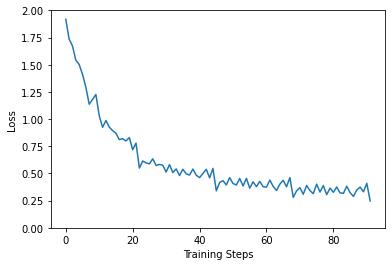

In [49]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

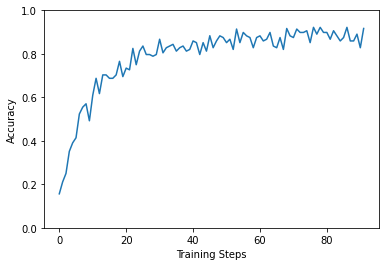

In [50]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [51]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

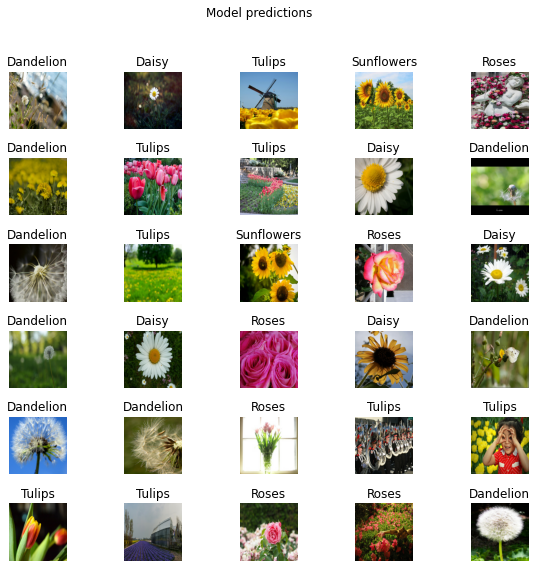

In [52]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics

In [54]:
labels_batch_arr = np.asarray(labels_batch)

In [55]:
predicted_id

array([1, 0, 4, 3, 2, 1, 4, 4, 0, 1, 1, 4, 3, 2, 0, 1, 0, 2, 0, 1, 1, 1,
       2, 4, 4, 4, 4, 2, 2, 1, 4, 2, 0, 2, 4, 1, 4, 1, 1, 1, 1, 0, 4, 0,
       1, 3, 3, 0, 1, 3, 3, 0, 1, 3, 4, 2, 0, 1, 2, 4, 4, 1, 4, 0, 4, 0,
       0, 4, 2, 4, 1, 0, 0, 4, 1, 4, 4, 4, 0, 1, 4, 2, 4, 3, 0, 0, 1, 2,
       2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 3, 2, 3, 1, 1, 3, 0, 0, 3, 2, 3, 4,
       2, 4, 1, 1, 1, 2, 1, 1, 0, 3, 1, 3, 3, 0, 4, 1, 1, 4])

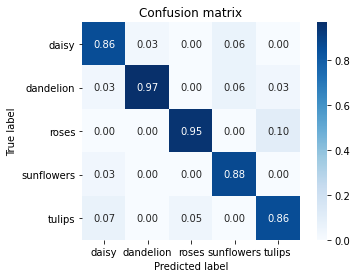

In [56]:
def show_confusion_matrix(test_labels, predictions):
  """Compute confusion matrix and normalize."""
  confusion = sk_metrics.confusion_matrix(
    labels_batch_arr, predicted_id)
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=0)
  axis_labels = class_names
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(labels_batch_arr, predicted_id)
